In [1]:
from common_func import *
if type_of_script() == 'jupyter': from tqdm.notebook import tqdm
else: from tqdm import tqdm
    
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib import colormaps
from matplotlib.colors import Normalize
import matplotlib.gridspec as gridspec
from mpl_toolkits.mplot3d import Axes3D, proj3d
#import cmasher as cmr

import numpy as np
import os, glob, atexit, signal, time, warnings, argparse, subprocess

from rur.fortranfile import FortranFile
from rur import uri, uhmi, painter, drawer
from rur.sci.photometry import measure_luminosity
from rur.sci.geometry import get_angles, euler_angle
from rur.utool import rotate_data
from scipy.ndimage import gaussian_filter
uri.timer.verbose=1

from icl_IO import mode2repo, pklsave, pklload
from icl_tool import *
from icl_numba import large_isin, large_isind, isin
from icl_draw import drawsnap, add_scalebar, addtext, MakeSub_nolabel, label_to_in, fancy_axis, circle

from importlib import reload
from copy import deepcopy
from multiprocessing import Pool, shared_memory, Value

# Analysis

## Data Preparation

In [2]:
mode1 = 'nh'
iout1 = 1026
repo, rurmode, dp = mode2repo(mode1)
nh1 = uri.RamsesSnapshot(repo, iout1, mode=rurmode)
nhs1 = uri.TimeSeries(nh1)
nhs1.read_iout_avail()
nout1 = nhs1.iout_avail['iout']
gals1 = uhmi.HaloMaker.load(nh1, galaxy=True, double_precision=dp)
hals1 = uhmi.HaloMaker.load(nh1, galaxy=False, double_precision=dp)
database1 = f"/home/jeon/MissingSat/database"
LG1 = pklload(f"{database1}/LG")
keys1 = []
for key in LG1.keys():
    if(LG1[key]['isLG']): keys1.append(key)
keys1 = np.array(keys1)

mode2 = 'nh2'
iout2 = 797
repo, rurmode, dp = mode2repo(mode2)
nh2 = uri.RamsesSnapshot(repo, iout2, mode=rurmode)
nhs2 = uri.TimeSeries(nh2)
nhs2.read_iout_avail()
nout2 = nhs2.iout_avail['iout']
gals2 = uhmi.HaloMaker.load(nh2, galaxy=True, double_precision=dp)
hals2 = uhmi.HaloMaker.load(nh2, galaxy=False, double_precision=dp)
database2 = f"/home/jeon/MissingSat/database/nh2"
LG2 = pklload(f"{database2}/LG")
keys2 = []
for key in LG2.keys():
    if(LG2[key]['isLG']): keys2.append(key)
keys2 = np.array(keys2)

[Output 01026] Age (Gyr) : 11.624 / 13.741, z = 0.17149 (a = 0.8536)
[Output 00797] Age (Gyr) : 11.623 / 13.741, z = 0.17158 (a = 0.8536)


In [3]:
allsubs1 = None
states1 = None
for key in LG1.keys():
    subs = LG1[key]['subs']
    assert (subs['Host'] == key).all()
    real = LG1[key]['real']
    dink = real[real['state']=='dink']['hid']
    dink_ind = isin(subs['id'], dink)
    subs['dink'][dink_ind] = True
    subs['dink'][~dink_ind] = False

    state = np.zeros(len(subs), dtype='<U7')
    state[dink_ind] = 'dink'
    state[~dink_ind] = 'pair'
    upair = real[real['state']=='upair']['hid']
    u_ind = isin(subs['id'], upair)
    state[u_ind] = 'upair'

    allsubs1 = subs if allsubs1 is None else np.hstack((allsubs1, subs))
    states1 = state if states1 is None else np.hstack((states1, state))
    # if(key==1): print(subs[state=='dink']['id'])
argsort = np.argsort(allsubs1['id'])
allsubs1 = allsubs1[argsort]; states1 = states1[argsort]
LGmask1 = isin(allsubs1['Host'], keys1)
# allsubs1 = allsubs1[LGmask1]; states1 = states1[LGmask1]
len(allsubs1)

3851

In [4]:
allsubs2 = None
states2 = None
for key in LG2.keys():
    subs = LG2[key]['subs']
    assert (subs['Host'] == key).all()
    real = LG2[key]['real']
    dink = real[real['state']=='dink']['hid']
    dink_ind = isin(subs['id'], dink)
    subs['dink'][dink_ind] = True
    subs['dink'][~dink_ind] = False
    state = np.zeros(len(subs), dtype='<U7')
    state[dink_ind] = 'dink'
    state[~dink_ind] = 'pair'
    upair = real[real['state']=='upair']['hid']
    u_ind = isin(subs['id'], upair)
    state[u_ind] = 'upair'

    allsubs2 = subs if allsubs2 is None else np.hstack((allsubs2, subs))
    states2 = state if states2 is None else np.hstack((states2, state))
argsort = np.argsort(allsubs2['id'])
allsubs2 = allsubs2[argsort]; states2 = states2[argsort]
LGmask2 = isin(allsubs2['Host'], keys2)
# allsubs2 = allsubs2[LGmask2]; states2 = states2[LGmask2]
len(allsubs2)


1242

In [5]:
subs1 = None; dinks1 = None; pairs1 = None; upairs1 = None
for key in keys1:
    tmp = LG1[key]['subs']
    subs1 = tmp if(subs1 is None) else np.hstack((subs1, tmp))

    real = LG1[key]['real']

    dink_hids = real[real['state'] == 'dink']['hid']
    tmp1 = tmp[isin(tmp['id'], dink_hids)]
    if(len(tmp1)>0):
        dinks1 = tmp1 if(dinks1 is None) else np.hstack((dinks1, tmp1))
    pair_hids = real[real['state'] == 'pair']['hid']
    tmp1 = tmp[isin(tmp['id'], pair_hids)]
    if(len(tmp1)>0):
        pairs1 = tmp1 if(pairs1 is None) else np.hstack((pairs1, tmp1))
    upair_hids = real[real['state'] == 'upair']['hid']
    tmp1 = tmp[isin(tmp['id'], upair_hids)]
    if(len(tmp1)>0):
        upairs1 = tmp1 if(upairs1 is None) else np.hstack((upairs1, tmp1))
print(len(subs1), len(dinks1), len(pairs1), len(upairs1))

subs2 = None; dinks2 = None; pairs2 = None; upairs2 = None
for key in keys2:
    tmp = LG2[key]['subs']
    subs2 = tmp if(subs2 is None) else np.hstack((subs2, tmp))

    real = LG2[key]['real']

    dink_hids = real[real['state'] == 'dink']['hid']
    tmp1 = tmp[isin(tmp['id'], dink_hids)]
    if(len(tmp1)>0):
        dinks2 = tmp1 if(dinks2 is None) else np.hstack((dinks2, tmp1))
    pair_hids = real[real['state'] == 'pair']['hid']
    tmp1 = tmp[isin(tmp['id'], pair_hids)]
    if(len(tmp1)>0):
        pairs2 = tmp1 if(pairs2 is None) else np.hstack((pairs2, tmp1))
    upair_hids = real[real['state'] == 'upair']['hid']
    tmp1 = tmp[isin(tmp['id'], upair_hids)]
    if(len(tmp1)>0):
        upairs2 = tmp1 if(upairs2 is None) else np.hstack((upairs2, tmp1))
print(len(subs2), len(dinks2), len(pairs2), len(upairs2))

1336 1145 130 61
1242 1120 79 43


# Mass Histogram

/tmp/ipykernel_16768/97970928.py:26: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([f"{int(y)}" for y in ytick])


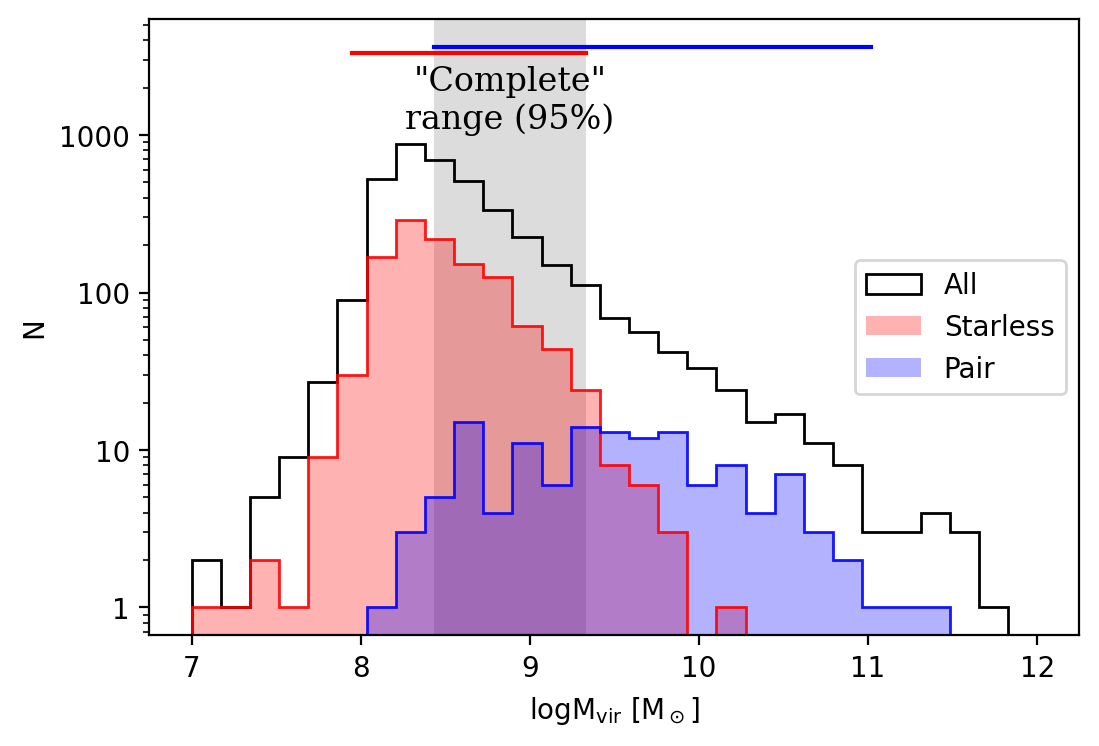

In [6]:
fig, ax = plt.subplots(ncols=1, figsize=(6,4), dpi=200)
plt.subplots_adjust(wspace=0)

mbins = np.linspace(7,12,30)
mleng = len(mbins)-1
xs = 0.5*(mbins[1:]+mbins[:-1])
colors = ['k', 'r', 'b', 'g']

m1d, m2d = np.nanpercentile(np.hstack((dinks1['mvir'],dinks2['mvir'])), q=[2.5,97.5])
m1p, m2p = np.nanpercentile(np.hstack((pairs1['mvir'],pairs2['mvir'])), q=[2.5,97.5])
m1 = np.max([m1d,m1p]); m2 = np.min([m2d,m2p])

colorcount = 0
ax.hist(np.log10(allsubs1['mvir']), bins=mbins, color=colors[colorcount],label='All', histtype='step'); colorcount+=1
ax.plot([np.log10(m1d), np.log10(m2d)], [3000*(1+colorcount/10),3000*(1+colorcount/10)], color=colors[colorcount])
ax.hist(np.log10(dinks1['mvir']), bins=mbins, color=colors[colorcount],label='Starless', histtype='stepfilled', alpha=0.3)
ax.hist(np.log10(dinks1['mvir']), bins=mbins, color=colors[colorcount], histtype='step', alpha=0.9); colorcount+=1
ax.plot([np.log10(m1p), np.log10(m2p)], [3000*(1+colorcount/10),3000*(1+colorcount/10)], color=colors[colorcount])
ax.hist(np.log10(pairs1['mvir']), bins=mbins, color=colors[colorcount],label='Pair', histtype='stepfilled', alpha=0.3)
ax.hist(np.log10(pairs1['mvir']), bins=mbins, color=colors[colorcount], histtype='step', alpha=0.9); colorcount+=1
ax.axvspan(np.log10(m1), np.log10(m2), ec='none', fc='gainsboro', zorder=-1)
ax.text((np.log10(m1)+np.log10(m2))/2, 1000, '"Complete"\nrange (95%)', ha='center', va='bottom', color='k', fontsize=12, family='serif')
ax.set_yscale('log')
ytick = ax.get_yticks()
ax.legend()
ax.set_yticklabels([f"{int(y)}" for y in ytick])
ax.set_xlabel(r'logM$_{\rm vir}$ [M$_\odot$]')
ax.set_ylabel(r'N')

# m1d, m2d = np.nanpercentile(dinks2['mvir'], q=[2.5,97.5])
# m1p, m2p = np.nanpercentile(pairs2['mvir'], q=[2.5,97.5])
# m1u, m2u = np.nanpercentile(upairs2['mvir'], q=[2.5,97.5])
# m1 = np.max([m1d,m1p,m1u]); m2 = np.min([m2d,m2p,m2u])

# colorcount = 0
# ax.hist(np.log10(allsubs2['mvir']), bins=mbins, color=colors[colorcount],label='All', histtype='step'); colorcount+=1
# ax.plot([np.log10(m1d), np.log10(m2d)], [2000*(1+colorcount/10),2000*(1+colorcount/10)], color=colors[colorcount])
# ax.hist(np.log10(dinks2['mvir']), bins=mbins, color=colors[colorcount],label='Starless', histtype='stepfilled', alpha=0.3)
# ax.hist(np.log10(dinks2['mvir']), bins=mbins, color=colors[colorcount],label='Starless', histtype='step', alpha=0.9); colorcount+=1
# ax.plot([np.log10(m1p), np.log10(m2p)], [2000*(1+colorcount/10),2000*(1+colorcount/10)], color=colors[colorcount])
# ax.hist(np.log10(pairs2['mvir']), bins=mbins, color=colors[colorcount],label='Pair', histtype='stepfilled', alpha=0.3)
# ax.hist(np.log10(pairs2['mvir']), bins=mbins, color=colors[colorcount],label='Pair', histtype='step', alpha=0.9); colorcount+=1
# ax.plot([np.log10(m1u), np.log10(m2u)], [2000*(1+colorcount/10),2000*(1+colorcount/10)], color=colors[colorcount])
# ax.hist(np.log10(upairs2['mvir']), bins=mbins, color=colors[colorcount],label='UDG-like', histtype='stepfilled', alpha=0.3)
# ax.hist(np.log10(upairs2['mvir']), bins=mbins, color=colors[colorcount],label='UDG-like', histtype='step', alpha=0.9); colorcount+=1
# ax.axvspan(np.log10(m1), np.log10(m2), ec='none', fc='gainsboro', zorder=-1)
# ax.text((np.log10(m1)+np.log10(m2))/2, 1000, '"Complete"\nrange (95%)', ha='center', va='bottom', color='k', fontsize=12, family='serif')
# ax.set_yscale('log')
# ytick = ax.get_yticks()
# ax.set_yticklabels([f"{int(y)}" for y in ytick])
# ax.set_xlabel(r'logM$_{\rm vir}$ [M$_\odot$]')
plt.savefig("04_NumberMass.png", dpi=400, transparent=False, facecolor='white', bbox_inches='tight', pad_inches=0.1)
plt.show(); plt.close()

## Mass Components

combine

  0%|          | 0/2265 [00:00<?, ?it/s]

/tmp/ipykernel_16768/596987802.py:30: RuntimeWarning: divide by zero encountered in log10
  ax.scatter(np.log10(iarr[mass_name]), np.log10(iarr[f'mcell{mass_suffix}']), facecolor=facecolor, edgecolor=edgecolor, s=50, lw=lw, zorder=zorder)
/tmp/ipykernel_16768/596987802.py:31: RuntimeWarning: divide by zero encountered in log10
  vmax = np.max([np.log10(iarr[f'mstar{mass_suffix}']), np.log10(iarr[f'mcell{mass_suffix}']), np.log10(iarr[f'mcold{mass_suffix}'])])
/tmp/ipykernel_16768/596987802.py:35: RuntimeWarning: divide by zero encountered in log10
  vmin = max( np.min([np.log10(iarr[f'mstar{mass_suffix}']), np.log10(iarr[f'mcell{mass_suffix}'])]), 3 )


  0%|          | 0/209 [00:00<?, ?it/s]

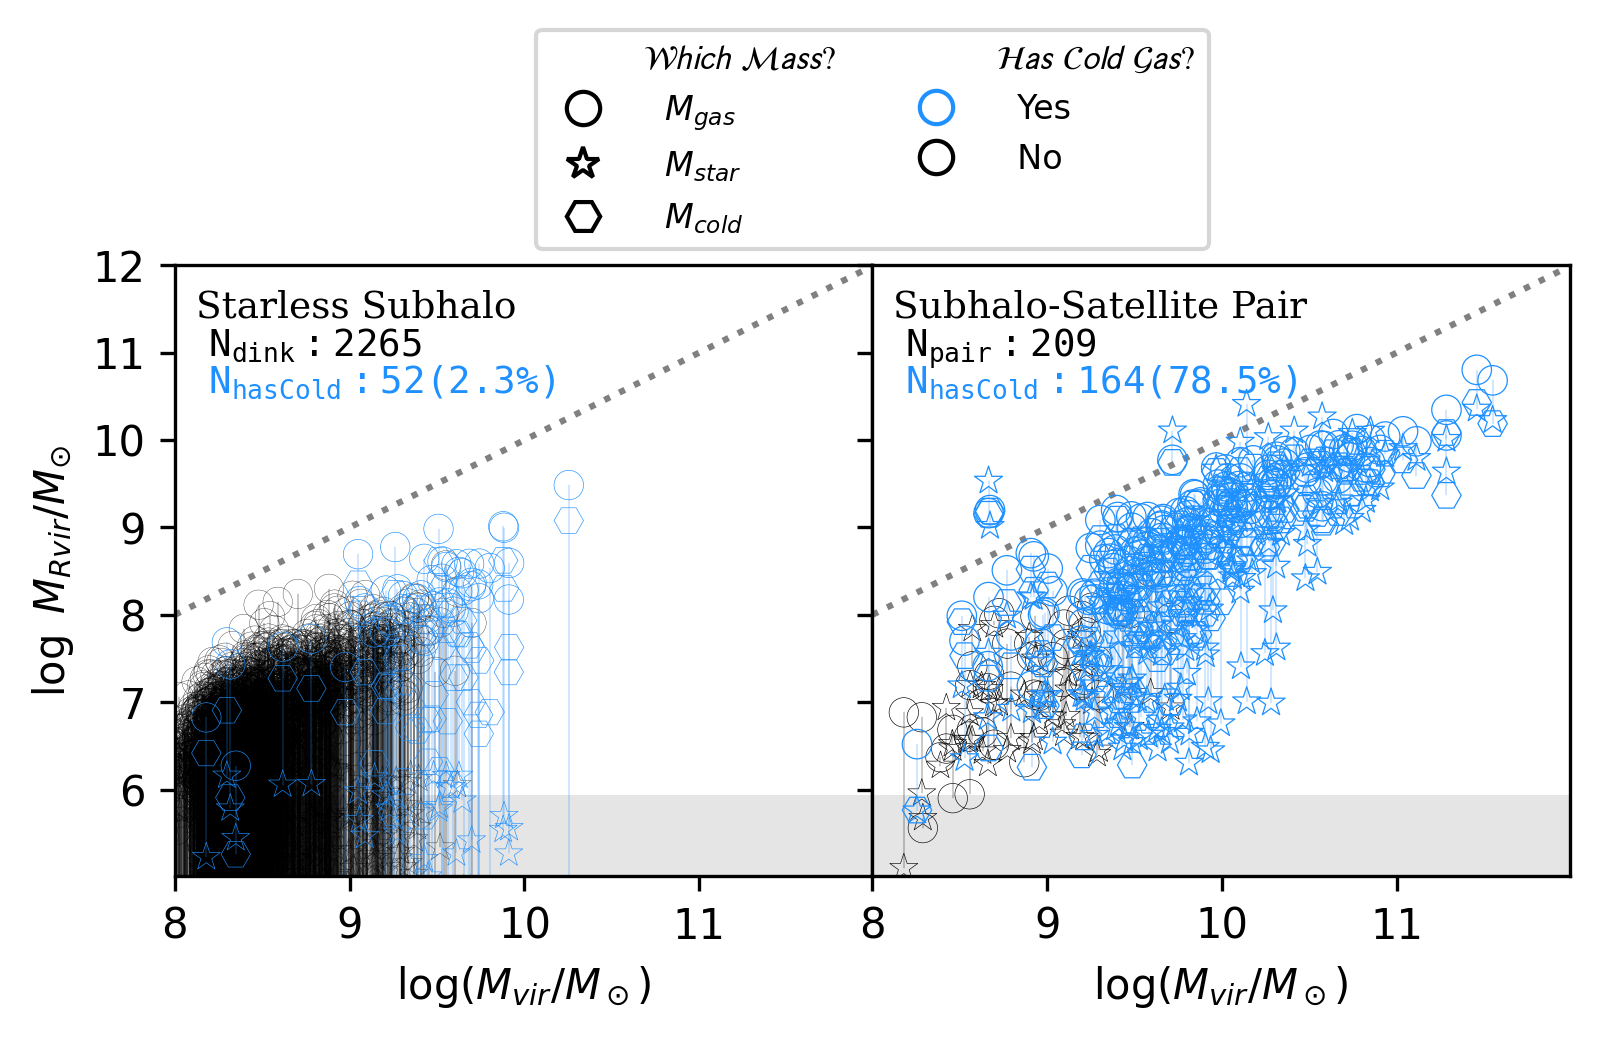

In [7]:
rname='Rvir'; mass_name='mvir'; xlabel='log($M_{vir}/M_\odot$)'
mass_suffix = "" if(mass_name=='mdm') else "_vir"
jump = False
if(not os.path.exists(f"03_components.png"))or(not jump):
    fig, axes = plt.subplots(ncols=2, dpi=300, figsize=(6,8), sharey=True)

    samples = [dinks1, pairs1, upairs1]
    samples2 = [dinks2, pairs2, upairs2]
    names = ["dink", "pair"]
    titles = ["Starless Subhalo", "Subhalo-Satellite Pair"]
    for i in range(2):
        ax = axes[i]
        sample = np.hstack((samples[i], samples2[i]))
        mask = sample[f'mcold{mass_suffix}'] < 1e3; sample[f'mcold{mass_suffix}'][mask] = 1e3
        mask = sample[f'mstar{mass_suffix}'] < 1e3; sample[f'mstar{mass_suffix}'][mask] = 1e3
        hascolds = sample[f'mcold{mass_suffix}']>1e3
        for iarr in tqdm(sample):
            hascold = iarr[f'mcold{mass_suffix}']>1e3
            color = 'k' if(not hascold) else 'dodgerblue'
            lw = 0.15 if(not hascold) else 0.3
            zorder = 0 if(not hascold) else 1
            facecolor='none'# if(isdink) else color
            edgecolor=color# if(isdink) else 'none' 
            linecolor=color
            if(i==0): lw/=2
            

            ax.scatter(np.log10(iarr[mass_name]), np.log10(iarr[f'mstar{mass_suffix}']), facecolor=facecolor, edgecolor=edgecolor, s=50, lw=lw, marker='*', zorder=zorder)
            if(iarr[f'mcold{mass_suffix}']>1e3): ax.scatter(np.log10(iarr[mass_name]), np.log10(iarr[f'mcold{mass_suffix}']), facecolor=facecolor, edgecolor=edgecolor, s=50, lw=lw, marker='H', zorder=zorder)
            ax.scatter(np.log10(iarr[mass_name]), np.log10(iarr[f'mcell{mass_suffix}']), facecolor=facecolor, edgecolor=edgecolor, s=50, lw=lw, zorder=zorder)
            vmax = np.max([np.log10(iarr[f'mstar{mass_suffix}']), np.log10(iarr[f'mcell{mass_suffix}']), np.log10(iarr[f'mcold{mass_suffix}'])])
            if(iarr[f'mcold{mass_suffix}']>1e3): 
                vmin = max( np.min([np.log10(iarr[f'mstar{mass_suffix}']), np.log10(iarr[f'mcell{mass_suffix}']), np.log10(iarr[f'mcold{mass_suffix}'])]), 3 )
            else:
                vmin = max( np.min([np.log10(iarr[f'mstar{mass_suffix}']), np.log10(iarr[f'mcell{mass_suffix}'])]), 3 )
            ax.plot([np.log10(iarr[mass_name]),np.log10(iarr[mass_name])], [vmin, vmax], color=linecolor, lw=0.1, zorder=zorder)

        ax.text(0.03, 0.96, f"{titles[i]}", ha='left', va='top', color='k', fontsize=9, transform=ax.transAxes, family='serif')
        ax.text(0.03, 0.90, fr"$\mathtt{{ \ N_{{{names[i]}}}: {len(sample)} }}$", ha='left', va='top', color='k', fontsize=9, transform=ax.transAxes)
        ax.text(0.03, 0.84, fr"$\mathtt{{ \ N_{{hasCold}}: {np.sum(hascolds)}({np.sum(hascolds)/len(sample)*100:.1f}\%) }}$", ha='left', va='top', color='dodgerblue', fontsize=9, transform=ax.transAxes)

    icol = 0
    for ax in axes.flatten():
        ax.fill_between([7.9,12.1],3, np.log10(np.min(gals1['m'])), ec='none', fc='grey', alpha=0.2, zorder=-1)

        ax.set_xlim(8,11.99)
        xlim = ax.get_xlim()
        ax.plot(xlim, xlim, ls=':', color='grey', zorder=-1)
        ax.set_ylim(5.01,12)
        if(icol==0): ax.set_ylabel(fr"$\log\ M_{{{rname}}}/M_{{\odot}}$")
        ax.set_xlabel(xlabel)
        icol += 1


    # Making Legend
    from matplotlib.lines import Line2D
    axes[0].set_aspect(1/2)
    axes[1].set_aspect(1/2)
    legend_elements = [
        Line2D([0],[0], marker='.',color='none', markeredgecolor='k', markerfacecolor='none', markersize=0, label=r'$\mathcal{Which\ Mass?}$'),
        Line2D([0],[0], marker='o',color='none', markeredgecolor='k', markerfacecolor='none', markersize=8, label=r'  $M_{gas}$'),
        Line2D([0],[0], marker='*',color='none', markeredgecolor='k', markerfacecolor='none', markersize=8, label=r'  $M_{star}$'),
        Line2D([0],[0], marker='H',color='none', markeredgecolor='k', markerfacecolor='none', markersize=8, label=r'  $M_{cold}$'),
        Line2D([0],[0], marker='.',color='none', markeredgecolor='k', markerfacecolor='none', markersize=0, label=r'$\mathcal{Has\ Cold\ Gas?}$'),
        Line2D([0],[0], marker='o',color='none', markerfacecolor='none', markeredgecolor='dodgerblue', markersize=8, label='  Yes'),
        Line2D([0],[0], marker='o',color='none', markerfacecolor='none', markeredgecolor='k', markersize=8, label='  No'),
    ]

    plt.subplots_adjust(hspace=0, wspace=0)
    axes[1].legend(handles=legend_elements, loc='lower center', bbox_to_anchor=(0, 1), fontsize=8, ncols=2)

    plt.savefig(f"03_components.png", dpi=400, transparent=False, facecolor='white', bbox_inches='tight', pad_inches=0.1)
    plt.show(); plt.close()

complete

In [8]:
np.log10(m2)-np.log10(m1)

0.9014034043600105

  0%|          | 0/1071 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

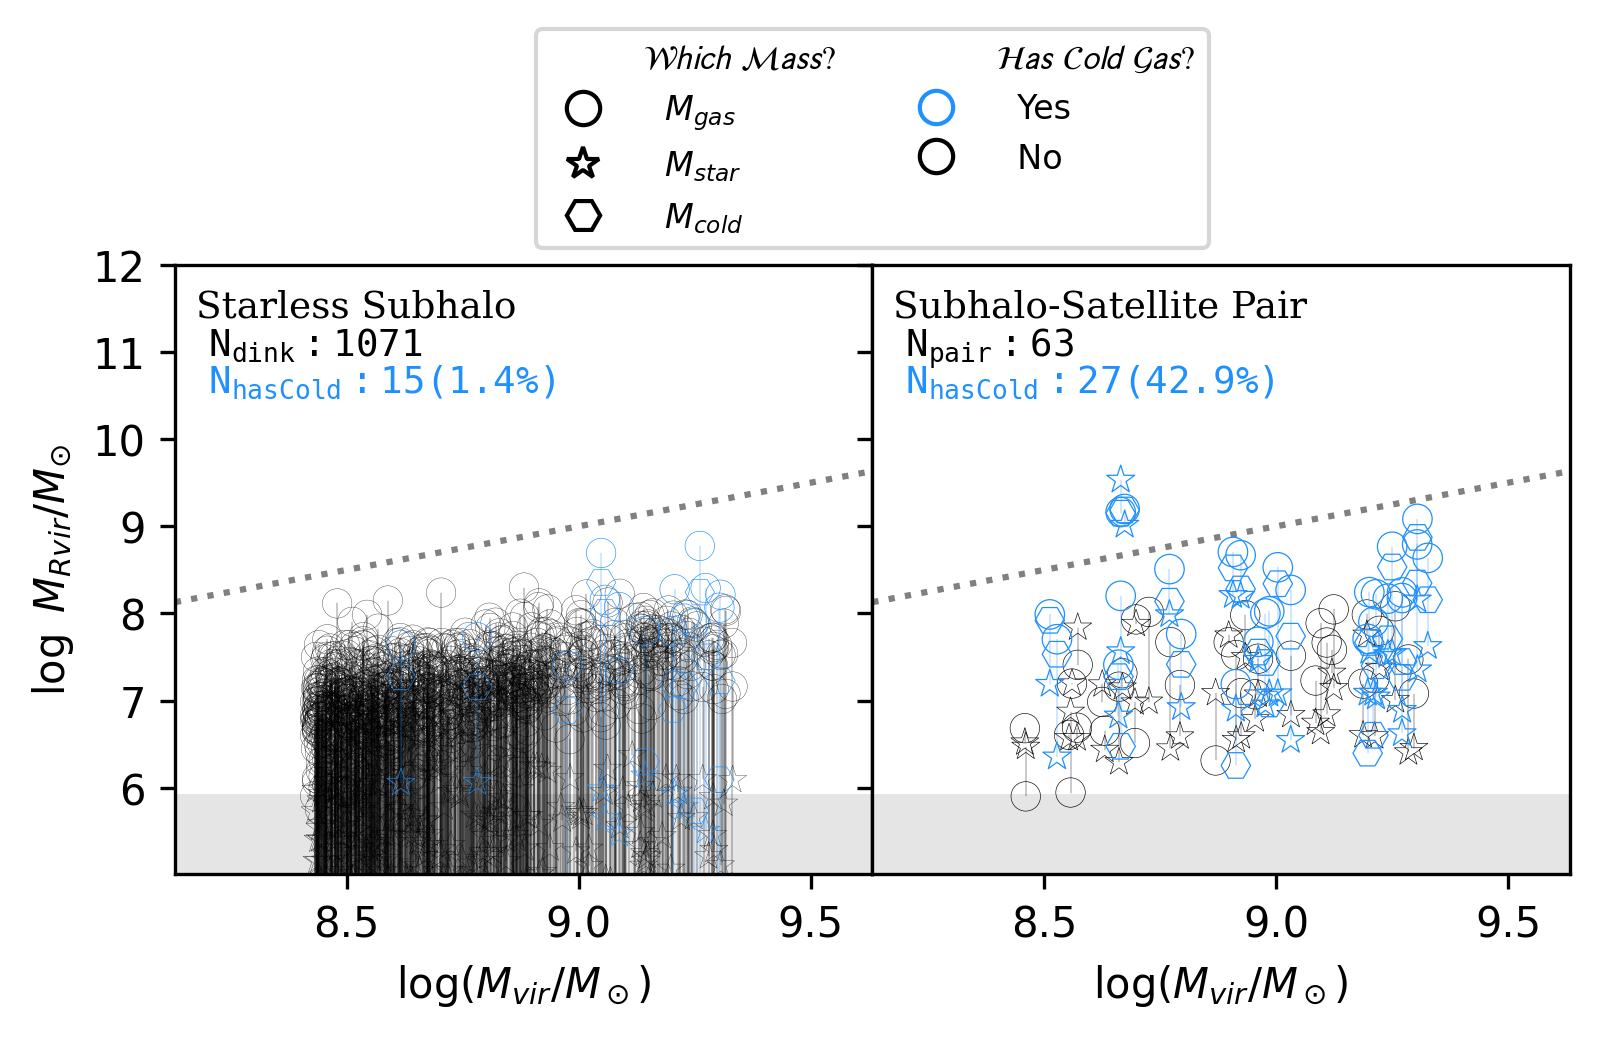

In [9]:
rname='Rvir'; mass_name='mvir'; xlabel='log($M_{vir}/M_\odot$)'
mass_suffix = "" if(mass_name=='mdm') else "_vir"
jump = False
if(not os.path.exists(f"03_components.png"))or(not jump):
    fig, axes = plt.subplots(ncols=2, dpi=300, figsize=(6,8), sharey=True)

    samples = [dinks1, pairs1, upairs1]
    samples2 = [dinks2, pairs2, upairs2]
    names = ["dink", "pair"]
    titles = ["Starless Subhalo", "Subhalo-Satellite Pair"]
    for i in range(2):
        ax = axes[i]
        sample = np.hstack((samples[i], samples2[i]))
        sample = sample[(sample['mvir']>=m1)&(sample['mvir']<=m2)]
        mask = sample[f'mcold{mass_suffix}'] < 1e3; sample[f'mcold{mass_suffix}'][mask] = 1e3
        mask = sample[f'mstar{mass_suffix}'] < 1e3; sample[f'mstar{mass_suffix}'][mask] = 1e3
        hascolds = sample[f'mcold{mass_suffix}']>1e3
        for iarr in tqdm(sample):
            hascold = iarr[f'mcold{mass_suffix}']>1e3
            color = 'k' if(not hascold) else 'dodgerblue'
            lw = 0.15 if(not hascold) else 0.3
            zorder = 0 if(not hascold) else 1
            facecolor='none'# if(isdink) else color
            edgecolor=color# if(isdink) else 'none' 
            linecolor=color
            if(i==0): lw/=2
            

            ax.scatter(np.log10(iarr[mass_name]), np.log10(iarr[f'mstar{mass_suffix}']), facecolor=facecolor, edgecolor=edgecolor, s=50, lw=lw, marker='*', zorder=zorder)
            if(iarr[f'mcold{mass_suffix}']>1e3): ax.scatter(np.log10(iarr[mass_name]), np.log10(iarr[f'mcold{mass_suffix}']), facecolor=facecolor, edgecolor=edgecolor, s=50, lw=lw, marker='H', zorder=zorder)
            ax.scatter(np.log10(iarr[mass_name]), np.log10(iarr[f'mcell{mass_suffix}']), facecolor=facecolor, edgecolor=edgecolor, s=50, lw=lw, zorder=zorder)
            vmax = np.max([np.log10(iarr[f'mstar{mass_suffix}']), np.log10(iarr[f'mcell{mass_suffix}']), np.log10(iarr[f'mcold{mass_suffix}'])])
            if(iarr[f'mcold{mass_suffix}']>1e3): 
                vmin = max( np.min([np.log10(iarr[f'mstar{mass_suffix}']), np.log10(iarr[f'mcell{mass_suffix}']), np.log10(iarr[f'mcold{mass_suffix}'])]), 3 )
            else:
                vmin = max( np.min([np.log10(iarr[f'mstar{mass_suffix}']), np.log10(iarr[f'mcell{mass_suffix}'])]), 3 )
            ax.plot([np.log10(iarr[mass_name]),np.log10(iarr[mass_name])], [vmin, vmax], color=linecolor, lw=0.1, zorder=zorder)

        ax.text(0.03, 0.96, f"{titles[i]}", ha='left', va='top', color='k', fontsize=9, transform=ax.transAxes, family='serif')
        ax.text(0.03, 0.90, fr"$\mathtt{{ \ N_{{{names[i]}}}: {len(sample)} }}$", ha='left', va='top', color='k', fontsize=9, transform=ax.transAxes)
        ax.text(0.03, 0.84, fr"$\mathtt{{ \ N_{{hasCold}}: {np.sum(hascolds)}({np.sum(hascolds)/len(sample)*100:.1f}\%) }}$", ha='left', va='top', color='dodgerblue', fontsize=9, transform=ax.transAxes)

    icol = 0
    for ax in axes.flatten():
        ax.fill_between([7.9,12.1],3, np.log10(np.min(gals1['m'])), ec='none', fc='grey', alpha=0.2, zorder=-1)

        ax.set_xlim(np.log10(m1/2),np.log10(m2*2))
        xlim = ax.get_xlim()
        ax.plot(xlim, xlim, ls=':', color='grey', zorder=-1)
        ax.set_ylim(5.01,12)
        if(icol==0): ax.set_ylabel(fr"$\log\ M_{{{rname}}}/M_{{\odot}}$")
        ax.set_xlabel(xlabel)
        icol += 1


    # Making Legend
    from matplotlib.lines import Line2D
    axes[0].set_aspect(np.log10(m2*4/m1)/4/2)
    axes[1].set_aspect(np.log10(m2*4/m1)/4/2)
    legend_elements = [
        Line2D([0],[0], marker='.',color='none', markeredgecolor='k', markerfacecolor='none', markersize=0, label=r'$\mathcal{Which\ Mass?}$'),
        Line2D([0],[0], marker='o',color='none', markeredgecolor='k', markerfacecolor='none', markersize=8, label=r'  $M_{gas}$'),
        Line2D([0],[0], marker='*',color='none', markeredgecolor='k', markerfacecolor='none', markersize=8, label=r'  $M_{star}$'),
        Line2D([0],[0], marker='H',color='none', markeredgecolor='k', markerfacecolor='none', markersize=8, label=r'  $M_{cold}$'),
        Line2D([0],[0], marker='.',color='none', markeredgecolor='k', markerfacecolor='none', markersize=0, label=r'$\mathcal{Has\ Cold\ Gas?}$'),
        Line2D([0],[0], marker='o',color='none', markerfacecolor='none', markeredgecolor='dodgerblue', markersize=8, label='  Yes'),
        Line2D([0],[0], marker='o',color='none', markerfacecolor='none', markeredgecolor='k', markersize=8, label='  No'),
    ]

    plt.subplots_adjust(hspace=0, wspace=0)
    axes[1].legend(handles=legend_elements, loc='lower center', bbox_to_anchor=(0, 1), fontsize=8, ncols=2)

    plt.savefig(f"03_components_comp.png", dpi=400, transparent=False, facecolor='white', bbox_inches='tight', pad_inches=0.1)
    plt.show(); plt.close()

# Function

In [75]:
def draw_analysis(yvalue, fname, yerrs=None,ymask=None, xname='mvir', ylabel='value', legkwargs={}, ylim=None, logscale=False):
    global allsubs1, states1, dinks1, pairs1, LGmask1
    global allsubs2, states2, dinks2, pairs2, LGmask2

    allsubs = np.hstack((allsubs1,allsubs2))
    states = np.hstack((states1,states2))
    LGmask = np.hstack((LGmask1,LGmask2))
    dinks = np.hstack((dinks1, dinks2))
    pairs = np.hstack((pairs1, pairs2))
    m1d, m2d = np.nanpercentile(dinks[xname], q=[2.5,97.5])
    m1p, m2p = np.nanpercentile(pairs[xname], q=[2.5,97.5])
    m1 = np.max([m1d,m1p]); m2 = np.min([m2d,m2p])

    mbins = np.linspace(7,12,9)
    mleng = len(mbins)-1
    xs = 0.5*(mbins[1:]+mbins[:-1])
    colors = ['k', 'r', 'b', 'g']
    

    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(8,8), dpi=150, sharey='row', sharex='col', gridspec_kw={'width_ratios': [4, 1], 'height_ratios': [1, 4]})
    AX = axes[1,0]
    if(logscale): AX.set_yscale('log')
    ax_right = axes[1,1]
    ax_top = axes[0,0]
    ax_top.set_ylabel("Normed Den.")

    # Dink
    # -------------------------------------------------------------------------
    color='tomato'
    mask = states=='dink'
    if(ymask is not None): mask = mask & ymask
    if(len(yvalue) != len(allsubs)):
        sample = allsubs[mask]
        val = yvalue[mask]
        if(yerrs is not None): err = yerrs[mask]
    else:
        sample = allsubs[mask & LGmask]
        val = yvalue[mask & LGmask]
        if(yerrs is not None): err = yerrs[mask & LGmask]

    if(yerrs is None): AX.scatter(np.log10(sample[xname]), val, s=5, ec=color,fc='none', label='Starless', marker='s')
    else: AX.errorbar(np.log10(sample[xname]), val, yerr=err, ms=5, mec=color,mfc='none', linewidth=0, ecolor=color, mew=0.4, elinewidth=0.4, capthick=0.4, capsize=3, marker='s', label='Starless')
    colorcount=1
    ys = np.zeros(mleng)-1; y16s = np.zeros(mleng)-1; y84s = np.zeros(mleng)-1
    for i in range(mleng):
        mask = (sample[xname] >= 10**mbins[i])&(sample[xname] < 10**mbins[i+1])
        if(np.sum(mask)>3):
            value = val[mask]
            y16s[i], ys[i], y84s[i] = np.nanpercentile(value, q=[16,50,84])
        else:
            y16s[i], ys[i], y84s[i] = np.nan,np.nan,np.nan
    mask = ~np.isnan(ys)
    AX.fill_between(xs[mask], y16s[mask], y84s[mask], fc=colors[colorcount], ec='none', alpha=0.2, zorder=5)
    AX.plot(xs[mask], ys[mask], color=colors[colorcount], zorder=6)
    colorcount+=1
    complete = (sample[xname] >= m1)&(sample[xname] <= m2)
    y0=np.nanmin(val[complete]); y1=np.nanmax(val[complete])
    if(ylim is not None): y0=ylim[0]; y1=ylim[1]
    if(logscale): y0=np.log10(y0); y1=np.log10(y1)
    bins = np.linspace(y0, y1, 20)
    if(logscale): bins = np.logspace(y0, y1, 20)
    ax_right.hist(val[complete], bins=bins, orientation='horizontal', color=color, histtype='step', density=True)
    q16,q50,q84 = np.nanpercentile(val[complete], q=[16,50,84])
    ax_right.axhline(q50, color=colors[1], label=fr"${q50:.2f}_{{-{q50-q16:.2f}}}^{{+{q84-q50:.2f}}}$")
    ax_right.axhspan(q16,q84, ec='none', fc=color, alpha=0.2, zorder=-1)
    ax_top.hist(np.log10(sample[xname]), bins=20, color=color, histtype='step', density=True)

    # Pair
    # -------------------------------------------------------------------------
    color='dodgerblue'
    mask = states=='pair'
    if(ymask is not None): mask = mask & ymask
    if(len(yvalue) != len(allsubs)):
        sample = allsubs[mask]
        val = yvalue[mask]
        if(yerrs is not None): err = yerrs[mask]
    else:
        sample = allsubs[mask & LGmask]
        val = yvalue[mask & LGmask]
        if(yerrs is not None): err = yerrs[mask & LGmask]

    if(yerrs is None): AX.scatter(np.log10(sample[xname]), val, s=5, ec=color,fc='none', label='Pair', marker='s')
    else: AX.errorbar(np.log10(sample[xname]), val, yerr=err, ms=5, mec=color,mfc='none', linewidth=0, ecolor=color, mew=0.4, elinewidth=0.4, capthick=0.4, capsize=3, marker='s', label='Pair')
    ys = np.zeros(mleng)-1; y16s = np.zeros(mleng)-1; y84s = np.zeros(mleng)-1
    for i in range(mleng):
        mask = (sample[xname] >= 10**mbins[i])&(sample[xname] < 10**mbins[i+1])
        if(np.sum(mask)>3):
            value = val[mask]
            y16s[i], ys[i], y84s[i] = np.nanpercentile(value, q=[16,50,84])
        else:
            y16s[i], ys[i], y84s[i] = np.nan,np.nan,np.nan
    mask = ~np.isnan(ys)
    AX.fill_between(xs[mask], y16s[mask], y84s[mask], fc=colors[colorcount], ec='none', alpha=0.2, zorder=5)
    AX.plot(xs[mask], ys[mask], color=colors[colorcount], zorder=6)
    colorcount+=1
    complete = (sample[xname] >= m1)&(sample[xname] <= m2)
    bins = np.linspace(np.nanmin(val[complete]), np.nanmax(val[complete]), 20)
    if(logscale): bins = np.logspace(np.nanmin(np.log10(val[complete])), np.nanmax(np.log10(val[complete])), 20)
    ax_right.hist(val[complete], bins=bins, orientation='horizontal', color=color, histtype='step', density=True)
    q16,q50,q84 = np.nanpercentile(val[complete], q=[16,50,84])
    ax_right.axhline(q50, color=colors[2], label=fr"${q50:.2f}_{{-{q50-q16:.2f}}}^{{+{q84-q50:.2f}}}$")
    ax_right.axhspan(q16,q84, ec='none', fc=color, alpha=0.2, zorder=-1)
    ax_top.hist(np.log10(sample[xname]), bins=20, color=color, histtype='step', density=True)


    AX.legend()
    ax_right.legend(**legkwargs)

    AX.axvspan(np.log10(m1), np.log10(m2), ec='none', fc='gainsboro', zorder=-1)
    ax_top.axvspan(np.log10(m1), np.log10(m2), ec='none', fc='gainsboro', zorder=-1)
    ax_right.set_facecolor('gainsboro')
    ax_top.text((np.log10(m1)+np.log10(m2))/2, ax_top.get_ylim()[1]*0.9, '"Complete"\nrange', ha='center', va='top', color='k', fontsize=8, family='serif')
    if(xname=='mvir'): AX.set_xlabel(r'logM$_{\rm vir}$ [M$_\odot$]')
    elif(xname=='mdm_vir'): AX.set_xlabel(r'logM$_{\rm DM,vir}$ [M$_\odot$]')
    AX.set_ylabel(ylabel)
    ax_right.set_xlabel(r'Normed Den.')
    ax_right.set_xlim(0.001,)
    if(ylim is not None): AX.set_ylim(*ylim)
    plt.subplots_adjust(wspace=0, hspace=0)
    plt.savefig(fname, dpi=400, transparent=False, facecolor='white', bbox_inches='tight', pad_inches=0.1)
    plt.show(); plt.close()

## Size Mass Relation

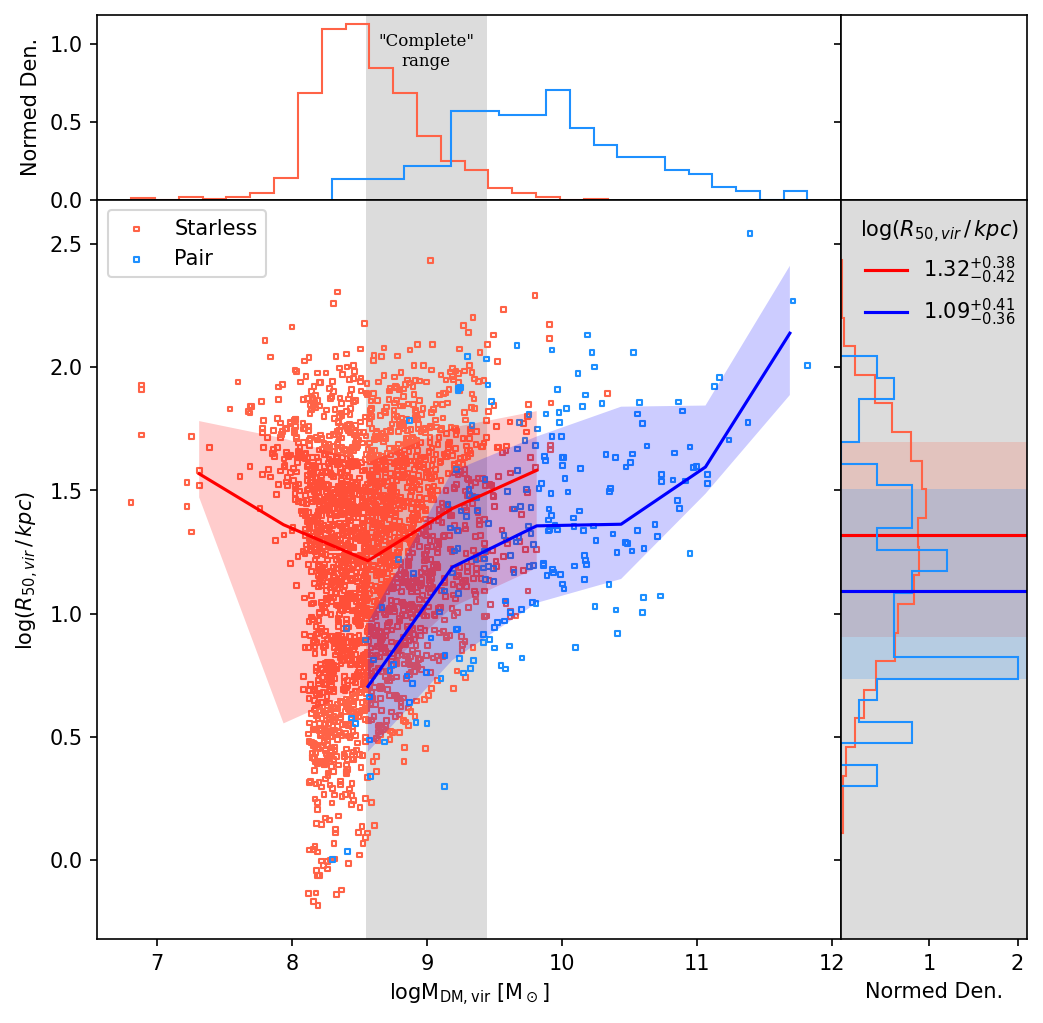

In [11]:
yvalue = np.hstack(( np.log10( allsubs1['r50_vir']/nh1.unit['kpc'] ), np.log10( allsubs2['r50_vir']/nh2.unit['kpc'] ) ))
fname = f"03_sizemass.png"
ylabel = r'log$(R_{50,vir}\,/\,kpc)$ '
legtitle = r'log$(R_{50,vir}\,/\,kpc)$ '
legkwargs = dict(title=legtitle, frameon=False)
draw_analysis(yvalue, fname, xname='mdm_vir', ylabel=ylabel, legkwargs=legkwargs)

## Anything

In [12]:
allsubs1.dtype

dtype([('nparts', '<i4'), ('id', '<i4'), ('timestep', '<i4'), ('level', '<i4'), ('host', '<i4'), ('hostsub', '<i4'), ('nbsub', '<i4'), ('nextsub', '<i4'), ('aexp', '<f8'), ('m', '<f8'), ('x', '<f8'), ('y', '<f8'), ('z', '<f8'), ('vx', '<f8'), ('vy', '<f8'), ('vz', '<f8'), ('Lx', '<f8'), ('Ly', '<f8'), ('Lz', '<f8'), ('r', '<f8'), ('a', '<f8'), ('b', '<f8'), ('c', '<f8'), ('ek', '<f8'), ('ep', '<f8'), ('et', '<f8'), ('spin', '<f8'), ('sigma', '<f8'), ('rvir', '<f8'), ('mvir', '<f8'), ('tvir', '<f8'), ('cvel', '<f8'), ('rho0', '<f8'), ('rc', '<f8'), ('mcontam', '<f8'), ('r10_mem', '<f8'), ('r50_mem', '<f8'), ('r90_mem', '<f8'), ('r10_vir', '<f8'), ('r50_vir', '<f8'), ('r90_vir', '<f8'), ('r10_max', '<f8'), ('r50_max', '<f8'), ('r90_max', '<f8'), ('sub', '<i8'), ('dink', '?'), ('mdm', '<f8'), ('mstar', '<f8'), ('mcold', '<f8'), ('mcell', '<f8'), ('Host', '<i4'), ('r200kpc', '<f8'), ('m200', '<f8'), ('r200', '<f8'), ('mdm_vir', '<f8'), ('mstar_vir', '<f8'), ('mcell_vir', '<f8'), ('mcold_vi

In [96]:
allsubs[['a','b','c']][allsubs['c'] > allsubs['a']]

array([(0.0052949 , 0.01796986, 0.00781404),
       (0.00300906, 0.0041062 , 0.00353042),
       (0.00705889, 0.0339981 , 0.01671436), ...,
       (0.00183811, 0.00409946, 0.00250907),
       (0.00384591, 0.00318879, 0.00536482),
       (0.0014475 , 0.00133186, 0.00202713)],
      dtype={'names': ['a', 'b', 'c'], 'formats': ['<f8', '<f8', '<f8'], 'offsets': [128, 136, 144], 'itemsize': 421})

In [139]:
arr = np.vstack((allsubs['a'], allsubs['b'], allsubs['c'])).T
arr = -np.sort(-arr, axis=1)
a[ith],b[ith],c[ith], arr[ith]
# arr[np.argsort(arr, axis=0)].shape

(array([[0.00975664, 0.00653109, 0.00511946]]),
 array([[0.11050536, 0.04873055, 0.07103276]]),
 array([[0.02353285, 0.00819525, 0.00669859]]),
 array([0.03596836, 0.01113165, 0.00767098]))

In [137]:
arg[:,0].reshape(len(allsubs),1)

array([[0],
       [0],
       [0],
       ...,
       [0],
       [1],
       [0]])

In [135]:
arg[:,0]

array([0, 0, 0, ..., 0, 1, 0])

In [129]:
arr[b>a]

array([[0.01113165, 0.00767098, 0.03596836],
       [0.01680205, 0.01586846, 0.01832426],
       [0.00706329, 0.0049217 , 0.02783628],
       ...,
       [0.00547872, 0.00391931, 0.00585914],
       [0.00384591, 0.00318879, 0.00536482],
       [0.0014475 , 0.00133186, 0.00202713]])

In [131]:
b[b>a][0]

0.035968357670203205

In [128]:
arg[b>a]

array([[2, 0, 1],
       [2, 0, 1],
       [2, 0, 1],
       ...,
       [2, 0, 1],
       [2, 0, 1],
       [2, 0, 1]])

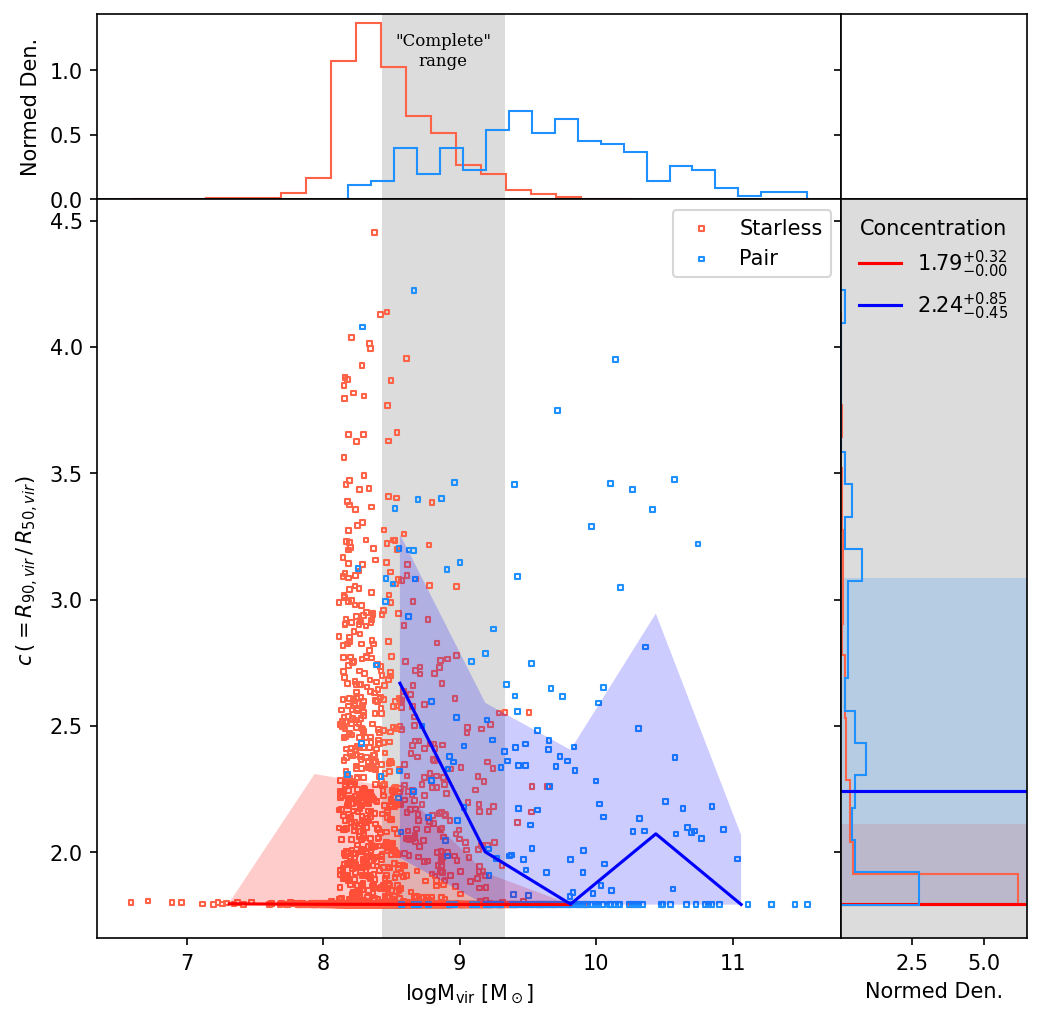

In [147]:
# yvalue = np.hstack((-allsubs1['ep']/allsubs1['ek'], -allsubs2['ep']/allsubs2['ek']))
allsubs = np.hstack((allsubs1, allsubs2))
# arr = np.vstack((allsubs['a'], allsubs['b'], allsubs['c'])).T
# arr = -np.sort(-arr, axis=1)
# a = arr[:,0]
# b = arr[:,1]
# c = arr[:,2]
# L = 1 + (b/a)**2 + (c/a)**2
# flat = np.sqrt( 1 - (c/b)**2 )
# elon = np.sqrt( 1 - (b/a)**2 )
# e = (1 - (c/a)**2) / 2 / L
# p = (1 - 2*((b/a)**2) + (c/a)**2) / 2 / L
# T = (1 - (b/a)**2) / (1 - (c/a)**2)
# yvalue = T
yvalue = np.log10(allsubs['rho0'])
# yvalue1 = (allsubs1['mstar_vir']+allsubs1['mcold_vir']) / (allsubs1['mcell_vir'])#+allsubs1['mstar_vir']+allsubs1['mcell_vir'])
# yvalue2 = (allsubs2['mstar_vir']+allsubs2['mcold_vir']) / (allsubs2['mcell_vir'])#+allsubs2['mstar_vir']+allsubs2['mcell_vir'])
# yvalue = np.hstack((yvalue1, yvalue2))
fname = f"03_Epot.png"
ylabel = r'$c\,(=R_{90,vir}\,/\,R_{50,vir})$ '
legtitle = r'Concentration'
legkwargs = dict(title=legtitle, frameon=False)
ylim = None
draw_analysis(yvalue, fname, xname='mvir', ylabel=ylabel, legkwargs=legkwargs, ylim=ylim)#, logscale=True)

## Concentration

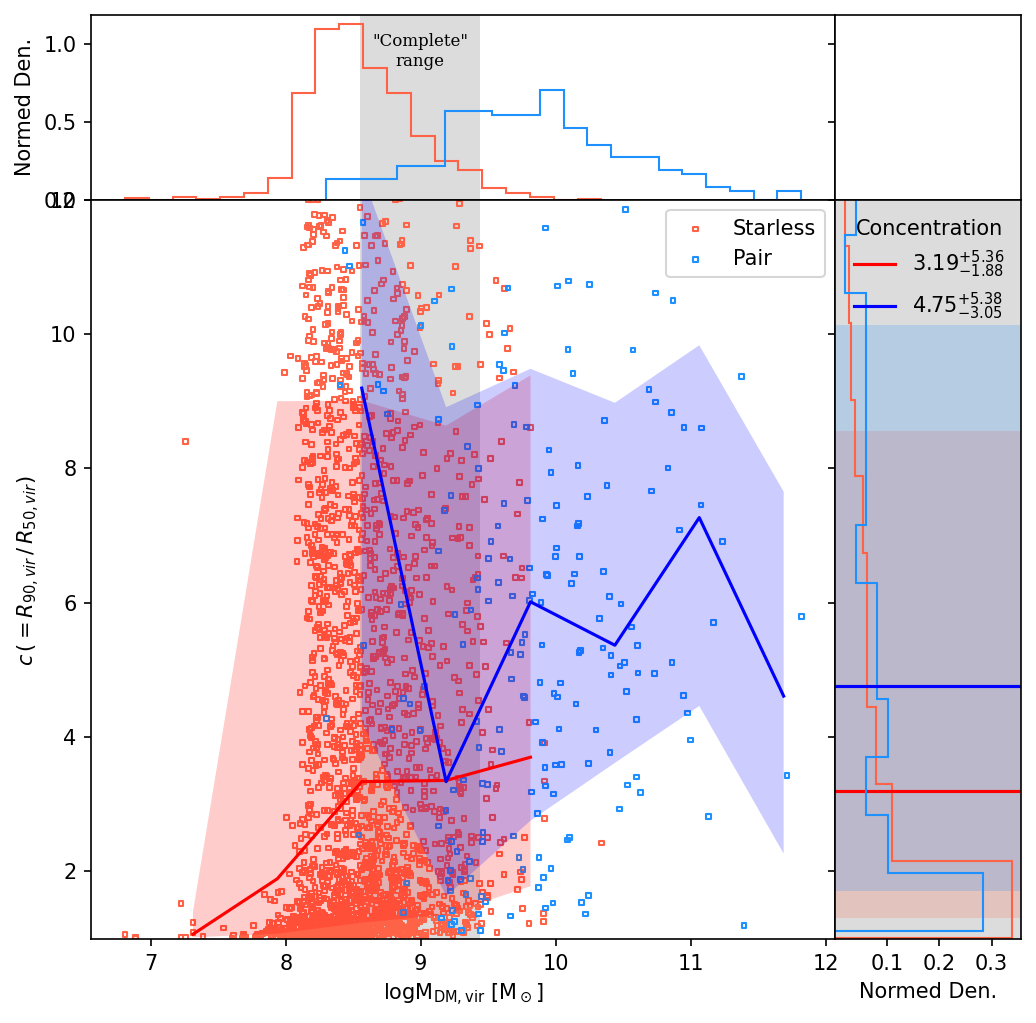

In [42]:
yvalue = np.hstack((allsubs1['r90_vir']/allsubs1['r10_vir'], allsubs2['r90_vir']/allsubs2['r10_vir']))
fname = f"03_concen.png"
ylabel = r'$c\,(=R_{90,vir}\,/\,R_{50,vir})$ '
legtitle = r'Concentration'
legkwargs = dict(title=legtitle, frameon=False)
ylim = (0.99, 12)
draw_analysis(yvalue, fname, xname='mdm_vir', ylabel=ylabel, legkwargs=legkwargs, ylim=ylim)

## Inner density slope

In [43]:
fname = f"{database1}/03_inner_slope.pickle"
density_slope1 = None
if(os.path.exists(fname)):
    density_slope1 = pklload(fname)

fname = f"{database2}/03_inner_slope.pickle"
density_slope2 = None
if(os.path.exists(fname)):
    density_slope2 = pklload(fname)

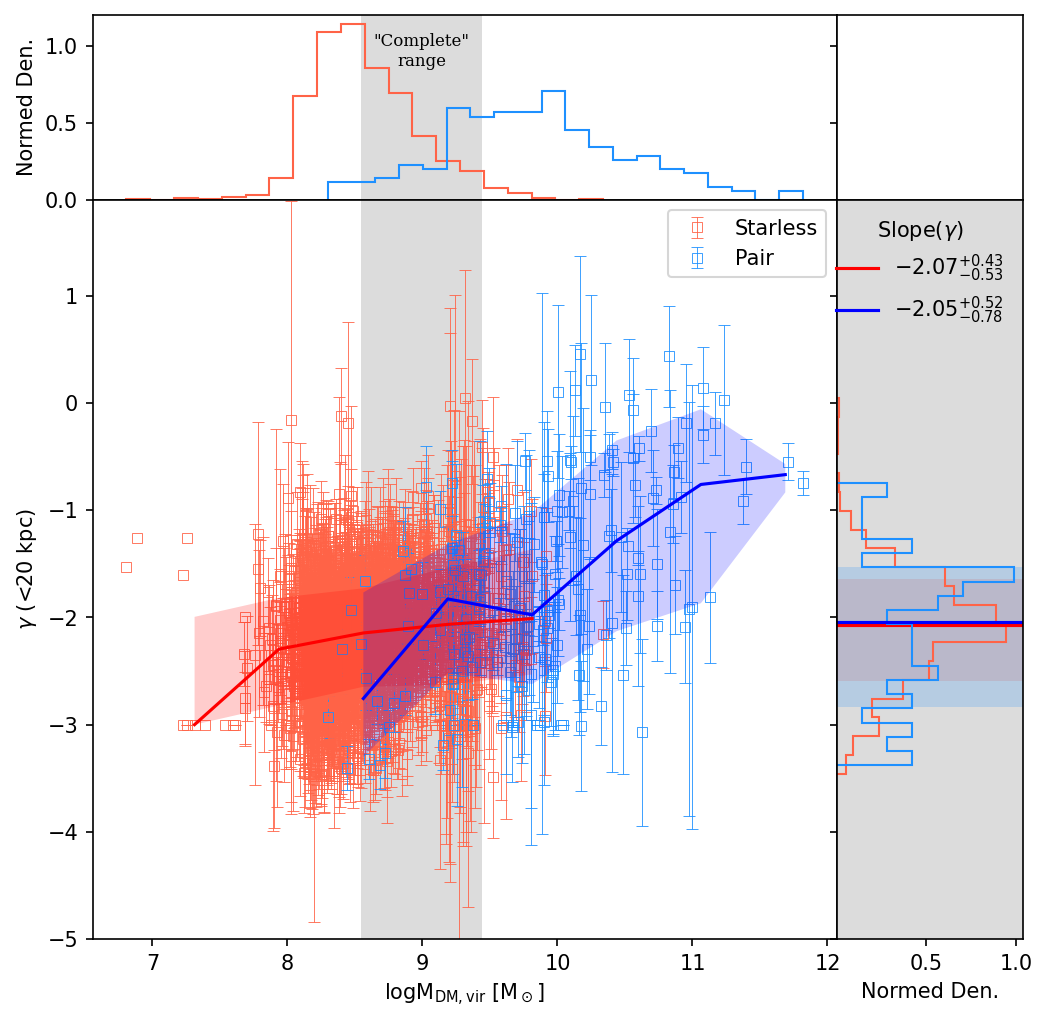

In [48]:
yvalue = np.hstack(( density_slope1['slope_vir'],density_slope2['slope_vir'] ))
yerrs = np.hstack(( density_slope1['err_vir'],density_slope2['err_vir'] ))
ymask = (yvalue > -3.49)&(yvalue<0.49)&(np.isfinite(yvalue))
fname = f"03_innerslope.png"
ylabel = r'$\gamma$ (<20 kpc)'
legtitle = r'Slope($\gamma$)'
legkwargs = dict(title=legtitle, frameon=False)
ylim = (-5,1.9)
draw_analysis(yvalue, fname,yerrs=yerrs, ymask=ymask, xname='mdm_vir', ylabel=ylabel, legkwargs=legkwargs, ylim=ylim)

## Total Density Slope

In [49]:
fname = f"{database1}/03_density_slope.pickle"
density_slope = None
if(os.path.exists(fname)):
    density_slope = pklload(fname)
ids1 = density_slope['subid']
denslops1 = density_slope['slope_tot']
densloperrs1 = density_slope['err_tot']

fname = f"{database2}/03_density_slope.pickle"
density_slope = None
if(os.path.exists(fname)):
    density_slope = pklload(fname)
ids2 = density_slope['subid']
denslops2 = density_slope['slope_tot']
densloperrs2 = density_slope['err_tot']

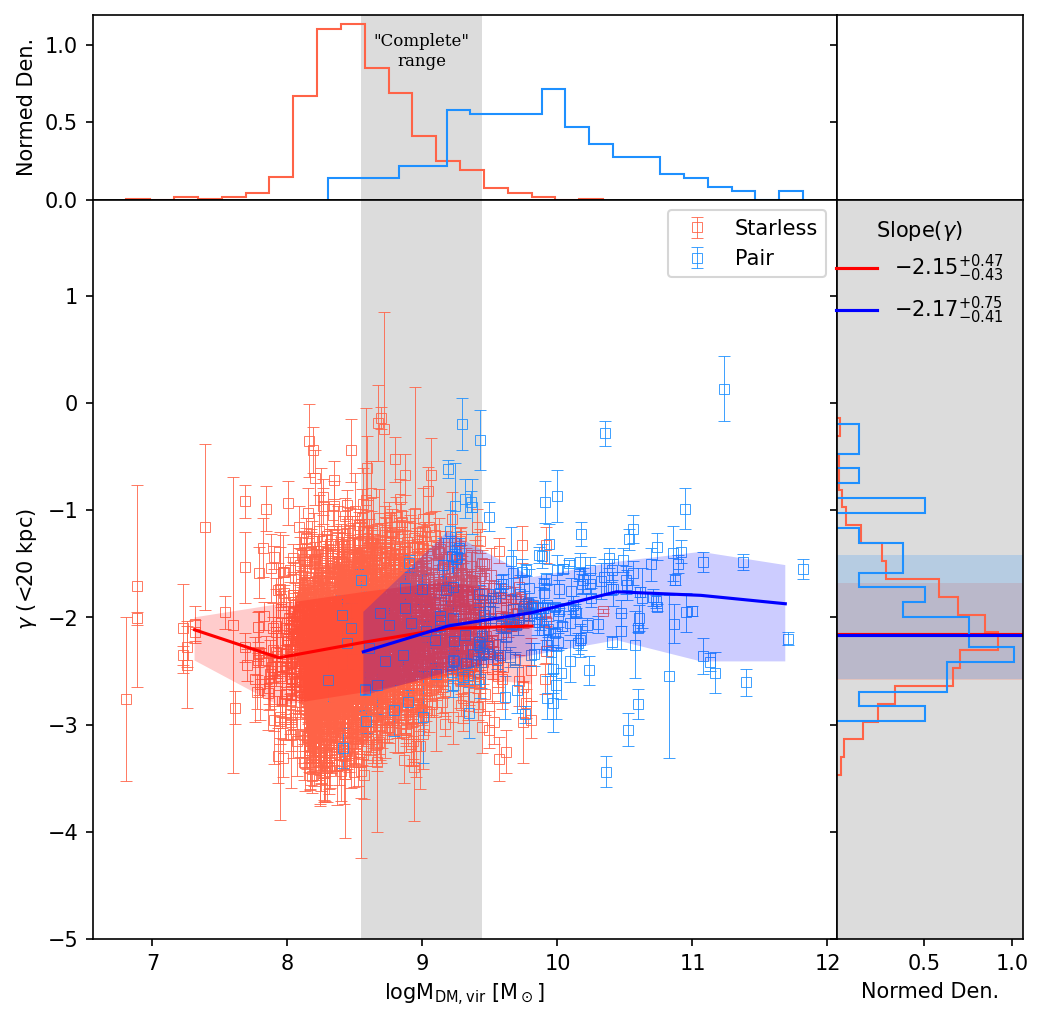

In [51]:
yvalue = np.hstack(( denslops1,denslops2 ))
yerrs = np.hstack(( densloperrs1,densloperrs2 ))
ymask = (yvalue > -3.49)&(yvalue<0.49)&(np.isfinite(yvalue))
fname = f"03_totalslope.png"
ylabel = r'$\gamma$ (<20 kpc)'
legtitle = r'Slope($\gamma$)'
legkwargs = dict(title=legtitle, frameon=False)
ylim = (-5,1.9)
draw_analysis(yvalue, fname,yerrs=yerrs,ymask=ymask, xname='mdm_vir', ylabel=ylabel, legkwargs=legkwargs, ylim=ylim)

## sAM

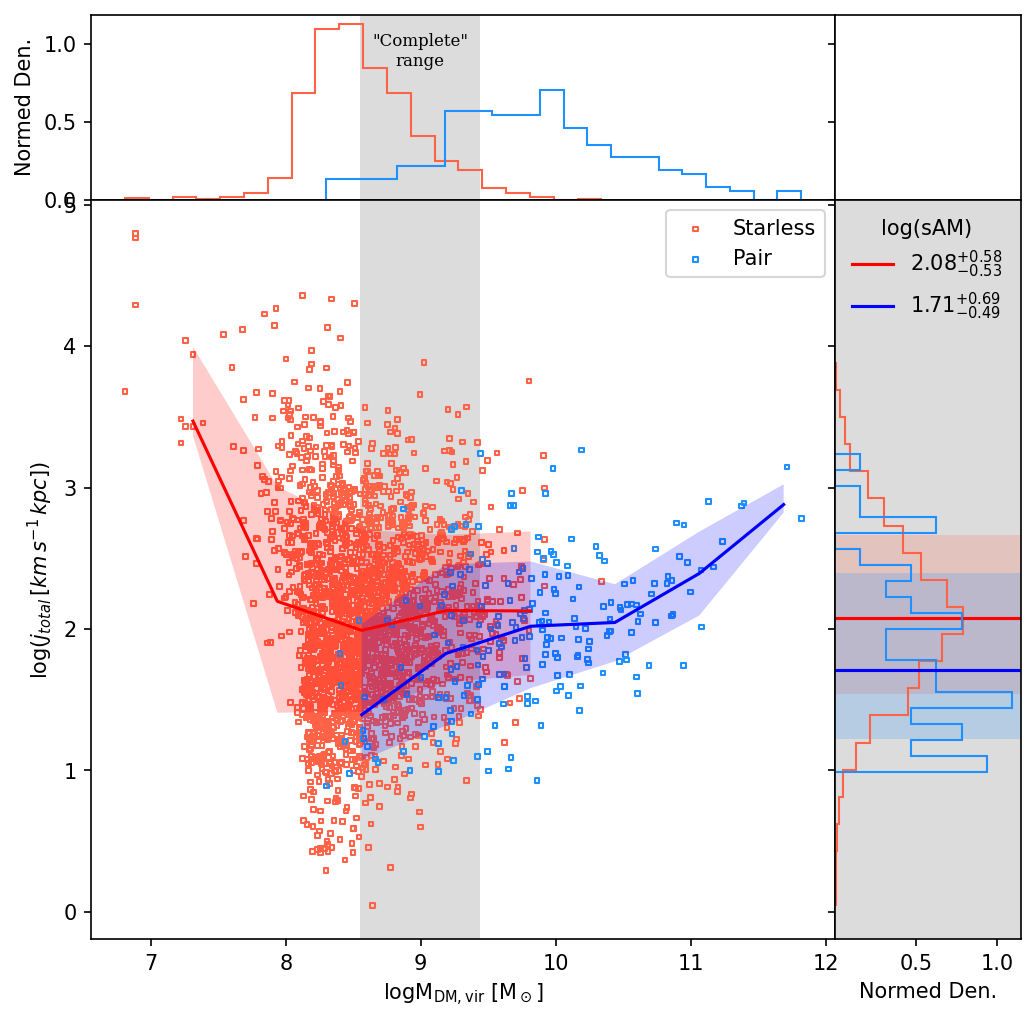

In [59]:
sample = np.hstack((allsubs1, allsubs2))
yvalue = np.log10(np.sqrt( sample['Lx']**2 + sample['Ly']**2 + sample['Lz']**2 ) / sample['mvir'])+3
yerrs = None
fname = f"03_angmom.png"
ylabel = r'log$(j_{total}\,[km\,s^{-1}\,kpc])$ '
legtitle = r'log(sAM)'
legkwargs = dict(title=legtitle, frameon=False)
ylim = None
draw_analysis(yvalue, fname,yerrs=yerrs, xname='mdm_vir', ylabel=ylabel, legkwargs=legkwargs, ylim=ylim)

In [ ]:
_